In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%matplotlib inline

In [3]:
sns.set(style="darkgrid")

## Read the data

In [60]:
hands = pd.read_csv("hands5.csv")

In [5]:
games = pd.read_csv("games5.csv")

### Test plots

## Basic hands analysis

### State statistics

A histogram with x labels indicate which state is which.

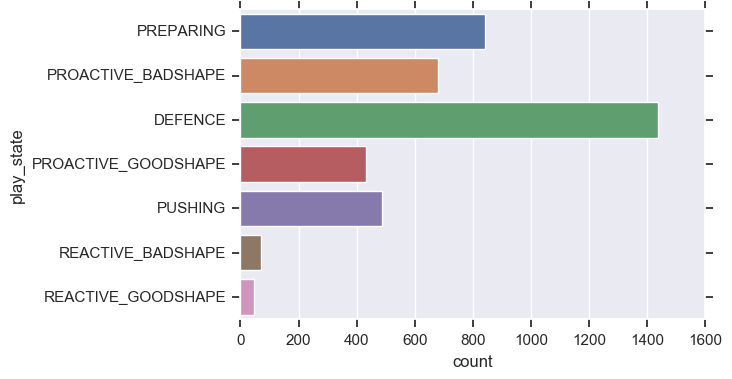

In [61]:
sns.countplot(y=hands["play_state"])

### State boxplot
I need to clearly see the average EV of each state.

Note that the "REACTIVE" data is too less. Not enough to adjust the algorithm.

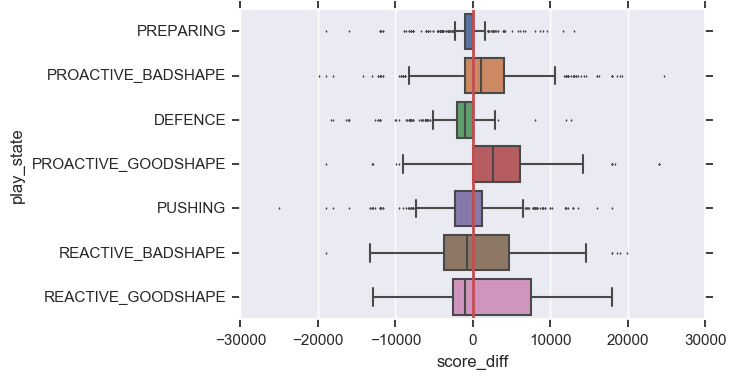

In [7]:
sns.boxplot(x="score_diff", y="play_state", data=hands, fliersize=1)
plt.axvline(color='r', linewidth=2)

### Score and meld times

(-10000, 10000)

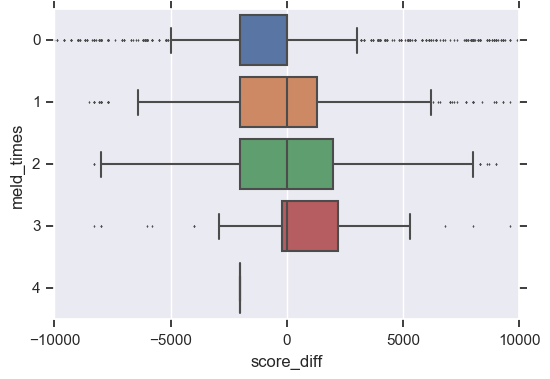

In [8]:
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands, fliersize=1)
ax.set_xlim(-10000, 10000)

### Defence when have melds

(-10000, 10000)

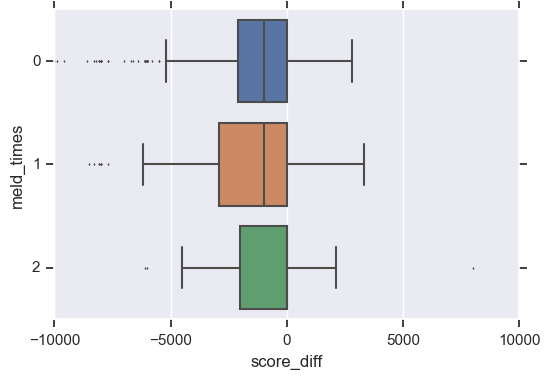

In [9]:
## defence when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] == "DEFENCE") & (hands["meld_times"] < 3)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Offense when have melds

(-10000, 10000)

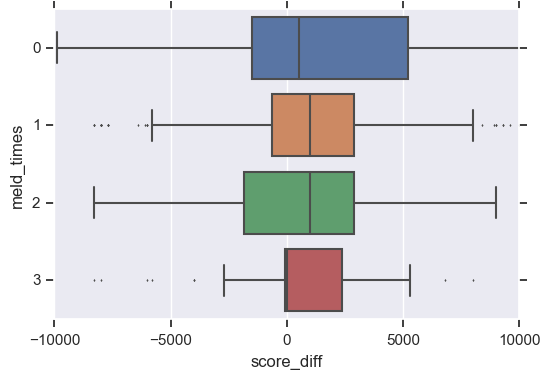

In [10]:
## offense when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] != "DEFENCE") & (hands["play_state"] != "PREPARING") & (hands["meld_times"] < 4)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Score and reach

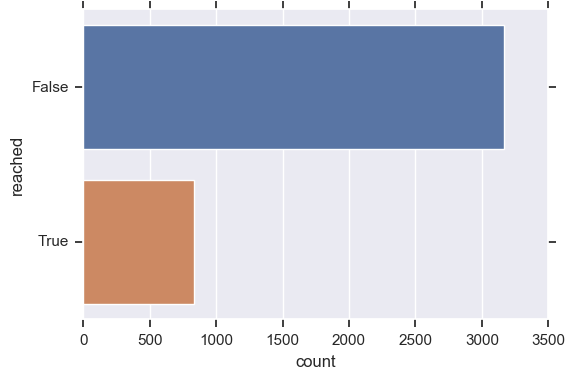

In [11]:
sns.countplot(y="reached", data=hands)

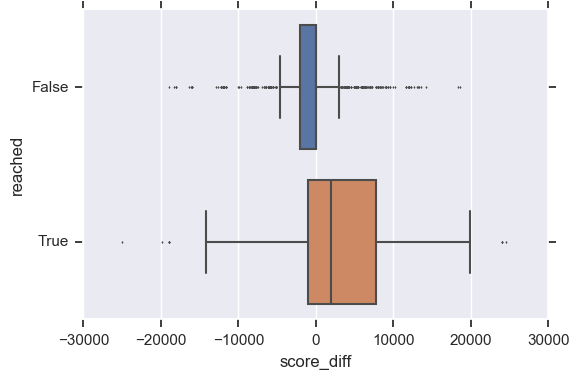

In [12]:
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands, fliersize=1)

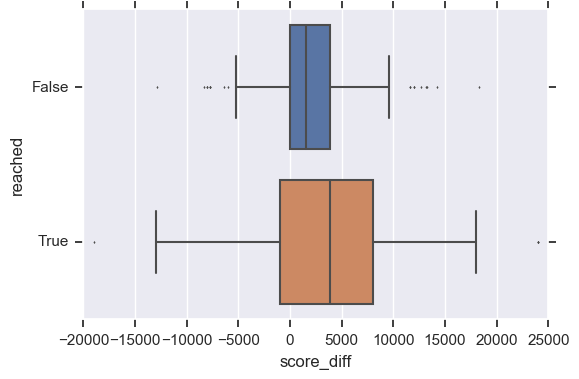

In [13]:
## GoodShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_GOODSHAPE") | (hands["play_state"]=="REACTIVE_GOODSHAPE")], fliersize=1)

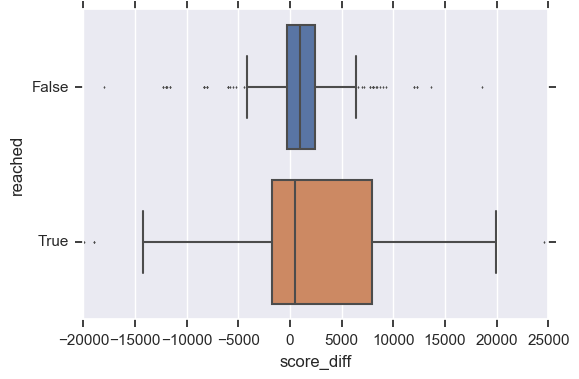

In [14]:
## BadShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_BADSHAPE") | (hands["play_state"]=="REACTIVE_BADSHAPE")], fliersize=1)

In hands2, the EV for badshape offense shows that reached is lower than unreached. After reaching condition for bad shape hands is tuned, this will be better.

### About game results

In [15]:
final_position = games["final_position"]
south_position = games["south_position"]

In [62]:
## south position ratio calculated
south_position_ratio = [(south_position==i).mean() for i in range(1,5)]
south_position_ratio

[0.16991643454038996,
 0.30362116991643456,
 0.28969359331476324,
 0.23676880222841226]

In [17]:
## final position ratio calculated
position_ratio = [(final_position==i).mean() for i in range(1,5)]
position_ratio

[0.1615598885793872,
 0.32590529247910865,
 0.28133704735376047,
 0.23119777158774374]

In [18]:
## Final Rate
current_rate = 1500

## Final Dan
i = 1
current_pt = 200
for play_count in range(3000):
    
    # change this to change the gamemode
    upper_dan = True
    phoenix = True
    
    delta_pt = [60, 15, 0]
    avg_rate = 1700
    if i >= 4 and current_rate >= 1800 and upper_dan:
        delta_pt = [75, 30, 0]
        avg_rate = 1900
    if i >= 7 and current_rate >= 2000 and phoenix:
        delta_pt = [90, 45, 0]
        avg_rate = 2100
    
    delta_pt.append(- (30 + i * 15))
    
    current_pt += np.dot(np.float32(delta_pt), position_ratio)
    delta_rate = np.dot(np.array(position_ratio), np.array([30, 10, -10, -30]))
    delta_rate += (avg_rate - current_rate) / 40
    current_rate += 0.2 * delta_rate
    
    if current_pt > i * 400:
        i += 1
        current_pt = i * 200
    elif current_pt < 0:
        i -= 1
        current_pt = i * 200
        
    if i > 10:
        print("Achieve 天凤 with play count {}".format(play_count))
        break
        
print("Final dan: {} with pt {}".format(i, current_pt))
print("Final rate: {}".format(current_rate))

Final dan: 3 with pt 484.17827298050247
Final rate: 1634.2617988857094


### South position and final position

In [19]:
_, row = next(games.iterrows())

In [20]:
pos_diff = np.zeros([4, 4])
for _, row in games.iterrows():
    pos_diff[row["final_position"]-1,row["south_position"]-1]+=1

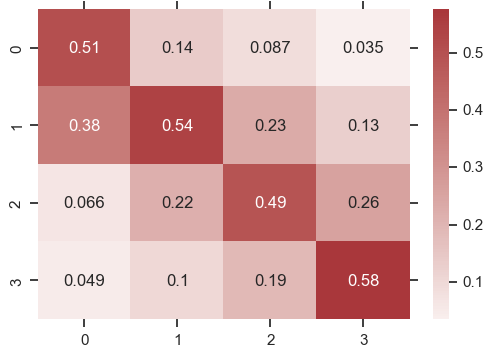

In [48]:
sns.heatmap(pos_diff/pos_diff.sum(axis=0), center=0, cmap="vlag", annot=True)

In [22]:
# score data preprocessing
score_preprocess = lambda x: int("".join(x.split(",")))
games["south_score"] = games["south_score"].apply(score_preprocess)
games["final_score"] = games["final_score"].apply(score_preprocess)

In [23]:
# Mean score
print("South main:", games["south_score"].mean(), games["south_position"].mean())
print("Final main:", games["final_score"].mean(), games["final_position"].mean())

South main: 24089.69359331476 2.5933147632311977
Final main: 23744.01114206128 2.582172701949861


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


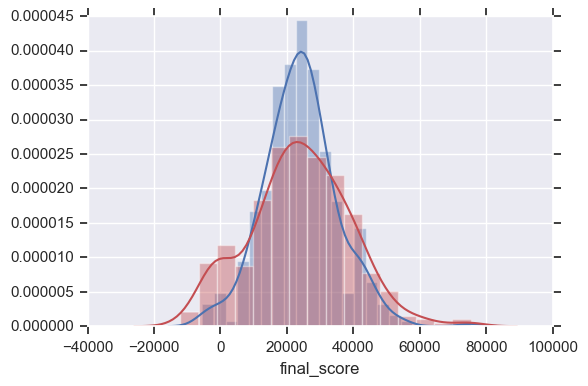

In [24]:
ax = sns.distplot(games["south_score"])
sns.distplot(games["final_score"], color="r", ax=ax)

## Defence

In [26]:
defence_hands = hands[hands["play_state"] == "DEFENCE"]

In [27]:
defence_hands.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,final_position
7,7,20100.0,-3900.0,DEFENCE,14,1,False,False,2019021812gm-0089-0000-51a49057&tw=0,4
10,10,13500.0,-2900.0,DEFENCE,6,1,False,False,2019021812gm-0089-0000-51a49057&tw=0,4
15,15,23200.0,-1500.0,DEFENCE,10,0,False,False,2019021812gm-0089-0000-51a49057&tw=0,4
16,16,21000.0,-2200.0,DEFENCE,10,0,False,False,2019021812gm-0089-0000-51a49057&tw=0,4
19,19,27000.0,0.0,DEFENCE,9,2,False,False,2019021813gm-0089-0000-4ef9e732&tw=2,3
20,20,27000.0,0.0,DEFENCE,10,0,False,False,2019021813gm-0089-0000-4ef9e732&tw=2,3
22,22,26000.0,0.0,DEFENCE,3,0,False,False,2019021813gm-0089-0000-4ef9e732&tw=2,3
23,23,25000.0,-1000.0,DEFENCE,5,0,False,False,2019021813gm-0089-0000-4ef9e732&tw=2,3
24,24,24500.0,-500.0,DEFENCE,4,0,False,False,2019021813gm-0089-0000-4ef9e732&tw=2,3
28,28,23600.0,-1400.0,DEFENCE,4,1,False,False,2019021813gm-0089-0000-28be5cdb&tw=3,3


In [28]:
print("Defence mean score diff:", defence_hands["score_diff"].mean())

Defence mean score diff: -1571.8858733472512


In [41]:
print("Lose big points when defence:", len(defence_hands[defence_hands["score_diff"] <= -6000])/len(defence_hands))

Lose big points when defence: 0.06541405706332637


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-10000, 250)

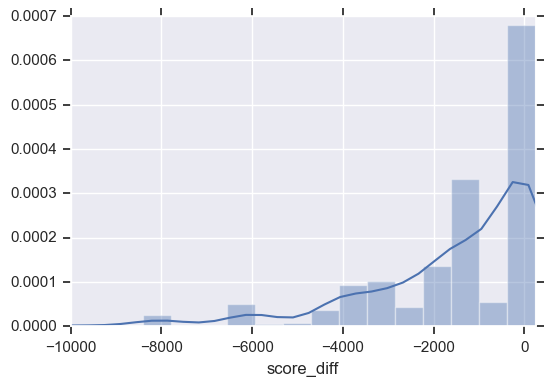

In [29]:
sns.distplot(defence_hands["score_diff"]).set_xlim(-10000, 250)

## Reasons why it got the 4th place

In [30]:
games_4th = games[games["final_position"] == 4]

In [31]:
hands_4th = hands[hands["final_position"] == 4]

### Play state with big score loss

In [32]:
hands_4th_bigloss = hands_4th[hands_4th["score_diff"] <= -6000]

In [33]:
hands_4th_bigloss.shape

(121, 10)

In [34]:
len(hands_4th_bigloss)/len(hands)

0.030272704528396296

In [35]:
hands_4th_bigloss.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,final_position
84,84,15400.0,-8600.0,PREPARING,0,0,False,False,2019021815gm-0089-0000-e7984f1c&tw=3,4
90,90,11800.0,-8000.0,PROACTIVE_GOODSHAPE,9,1,False,False,2019021815gm-0089-0000-e7984f1c&tw=3,4
95,95,11200.0,-12900.0,REACTIVE_GOODSHAPE,12,2,False,True,2019021815gm-0089-0000-e7984f1c&tw=3,4
217,217,11300.0,-13300.0,REACTIVE_BADSHAPE,10,0,True,False,2019021821gm-0089-0000-2d3f42e1&tw=1,4
220,220,1300.0,-6200.0,PUSHING,0,0,True,True,2019021821gm-0089-0000-2d3f42e1&tw=1,4
227,227,10700.0,-12000.0,PROACTIVE_BADSHAPE,3,0,False,False,2019021821gm-0089-0000-5929cc8f&tw=2,4
230,230,5500.0,-7700.0,PUSHING,0,2,False,False,2019021821gm-0089-0000-5929cc8f&tw=2,4
233,233,16300.0,-8700.0,REACTIVE_BADSHAPE,12,0,True,False,2019021822gm-0089-0000-1cc2c3fd&tw=2,4
298,298,18600.0,-6000.0,DEFENCE,7,0,False,False,2019021900gm-0089-0000-633d3f1d&tw=1,4
329,329,19000.0,-6000.0,PROACTIVE_GOODSHAPE,13,3,False,True,2019021902gm-0089-0000-a71146ce&tw=0,4


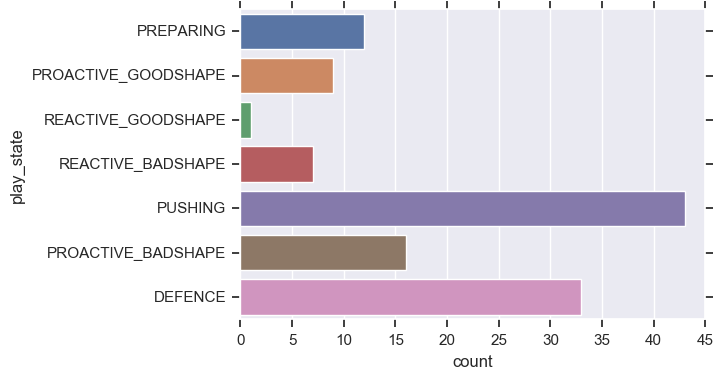

In [36]:
sns.countplot(y="play_state", data=hands_4th_bigloss)

### Category with south position

In [71]:
hands_S4 = hands[(hands["south_position"] == 4) & (hands["final_position"] == 4)]
hands_NS4 = hands[(hands["south_position"] != 4) & (hands["final_position"] == 4)]
print("South 4 final 4:", len(hands_S4)/len(hands))
print("South not 4 final 4:", len(hands_NS4)/len(hands))

South 4 final 4: 0.12784588441331
South not 4 final 4: 0.10557918438829123


### South 4 and final 4

In first 3 rounds, check which state cause big score loss.

In [83]:
hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)].head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
233,233,16300.0,-8700.0,REACTIVE_BADSHAPE,12,0,True,False,2019021822gm-0089-0000-1cc2c3fd&tw=2,0,4,4
329,329,19000.0,-6000.0,PROACTIVE_GOODSHAPE,13,3,False,True,2019021902gm-0089-0000-a71146ce&tw=0,0,4,4
368,368,16000.0,-9000.0,PROACTIVE_BADSHAPE,10,0,True,True,2019021904gm-0089-0000-8f27cab3&tw=0,0,4,4
369,369,4400.0,-11600.0,PREPARING,0,1,False,False,2019021904gm-0089-0000-8f27cab3&tw=0,1,4,4
370,370,-5500.0,-9900.0,DEFENCE,9,0,False,False,2019021904gm-0089-0000-8f27cab3&tw=0,1,4,4
781,29,16700.0,-8300.0,PROACTIVE_BADSHAPE,9,3,False,False,2019021813gm-0009-0000-d3688a6d&tw=1,0,4,4
782,30,10700.0,-6000.0,DEFENCE,6,0,False,True,2019021813gm-0009-0000-d3688a6d&tw=1,1,4,4
885,133,16300.0,-8700.0,PROACTIVE_BADSHAPE,7,0,True,False,2019021818gm-0089-0000-7bb76901&tw=1,0,4,4
1033,281,17000.0,-8000.0,PREPARING,0,2,False,True,2019021900gm-0089-0000-5de9152f&tw=0,0,4,4
1049,297,14400.0,-8000.0,PROACTIVE_BADSHAPE,6,2,False,True,2019021900gm-0089-0000-5de9152f&tw=0,1,4,4


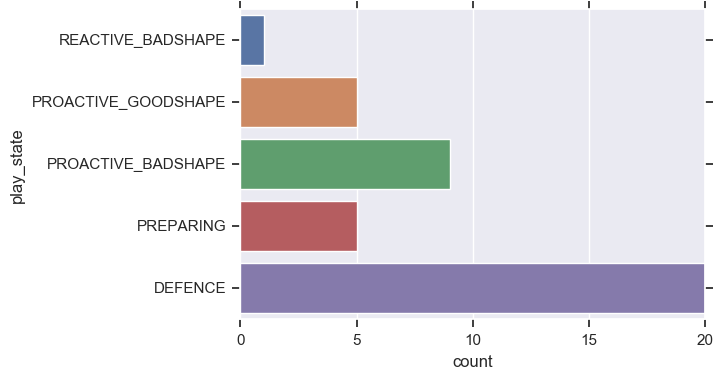

In [79]:
sns.countplot(y="play_state", data=hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)])

It seems like plenty of big score loss are caused by defence. Time to do some error analysis.

In [86]:
S4_defence_game_indexes = (hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2) & (hands_S4["play_state"] == "DEFENCE")]["game_index"]).unique()

In [88]:
for game_index in S4_defence_game_indexes:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019021904gm-0089-0000-8f27cab3&tw=0

http://tenhou.net/3/?log=2019021813gm-0009-0000-d3688a6d&tw=1

http://tenhou.net/3/?log=2019021902gm-0089-0000-c0e6454b&tw=2

http://tenhou.net/3/?log=2019021911gm-0089-0000-a2ca314a&tw=1

http://tenhou.net/3/?log=2019021915gm-0089-0000-e9ba26b8&tw=0

http://tenhou.net/3/?log=2019021816gm-0009-0000-f647a193&tw=0

http://tenhou.net/3/?log=2019021820gm-0009-0000-e1f60bbd&tw=3

http://tenhou.net/3/?log=2019021900gm-0009-0000-d3f31ff9&tw=2

http://tenhou.net/3/?log=2019021919gm-0009-0000-5db1375d&tw=3

http://tenhou.net/3/?log=2019021900gm-0009-0000-9d9bc46e&tw=1

http://tenhou.net/3/?log=2019021903gm-0009-0000-eaa821d4&tw=2

http://tenhou.net/3/?log=2019021903gm-0009-0000-7c55d44f&tw=1

http://tenhou.net/3/?log=2019021905gm-0009-0000-d6b9b254&tw=3

http://tenhou.net/3/?log=2019021906gm-0009-0000-a9f41e01&tw=3

http://tenhou.net/3/?log=2019021919gm-0009-0000-983b3147&tw=1

http://tenhou.net/3/?log=2019021822gm-0009-0000-8134710

### South not 4 and final 4

See why there are big score losses in south rounds.

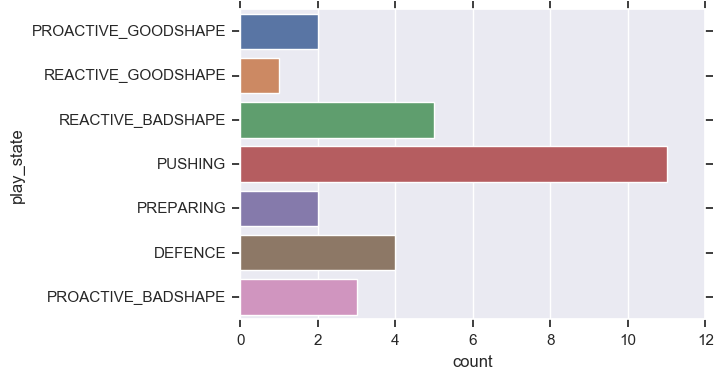

In [80]:
sns.countplot(y="play_state", data=hands_NS4[(hands_NS4["round_num"] >= 4) & (hands_NS4["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


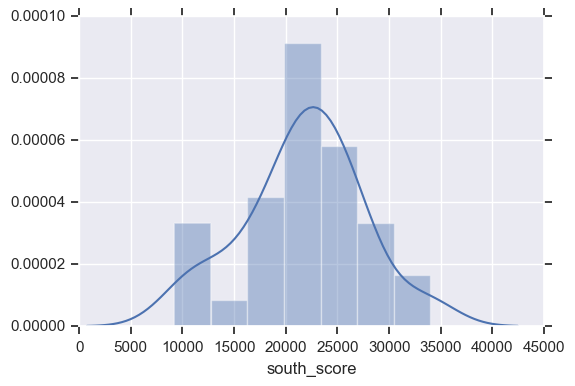

In [96]:
sns.distplot(games[(games["south_position"] != 4) & (games["final_position"] == 4)]["south_score"])

In [89]:
for game_index in hands_NS4["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019021815gm-0089-0000-e7984f1c&tw=3

http://tenhou.net/3/?log=2019021821gm-0089-0000-2d3f42e1&tw=1

http://tenhou.net/3/?log=2019021900gm-0089-0000-633d3f1d&tw=1

http://tenhou.net/3/?log=2019021903gm-0089-0000-f790e5dd&tw=1

http://tenhou.net/3/?log=2019021914gm-0089-0000-51986fb6&tw=1

http://tenhou.net/3/?log=2019021814gm-0009-0000-d1f28565&tw=0

http://tenhou.net/3/?log=2019021900gm-0089-0000-b1bb0eee&tw=3

http://tenhou.net/3/?log=2019021903gm-0089-0000-dafb28de&tw=2

http://tenhou.net/3/?log=2019021911gm-0089-0000-9314d726&tw=3

http://tenhou.net/3/?log=2019021911gm-0089-0000-f325ee9a&tw=3

http://tenhou.net/3/?log=2019021914gm-0089-0000-4a489e1b&tw=2

http://tenhou.net/3/?log=2019021918gm-0089-0000-9b68687b&tw=0

http://tenhou.net/3/?log=2019021817gm-0009-0000-6242f210&tw=2

http://tenhou.net/3/?log=2019021819gm-0009-0000-23ed7158&tw=2

http://tenhou.net/3/?log=2019021822gm-0009-0000-96fc521e&tw=2

http://tenhou.net/3/?log=2019021823gm-0009-0000-e10e5af

### South 1 and final not 1

In [81]:
hands_S1 = hands[(hands["south_position"] == 1) & (hands["final_position"] != 1)]

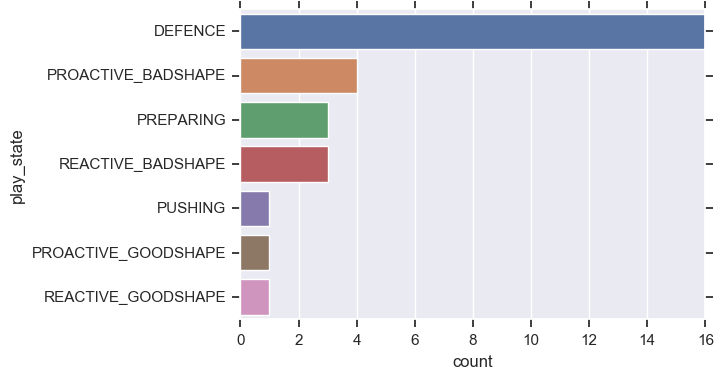

In [90]:
# more than -3900
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -3900)])

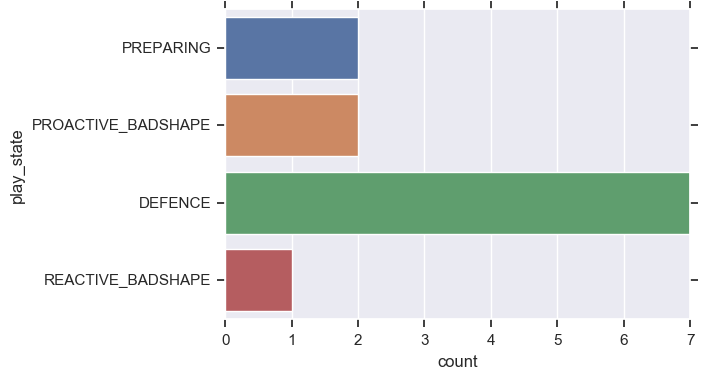

In [91]:
# more than -6000
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


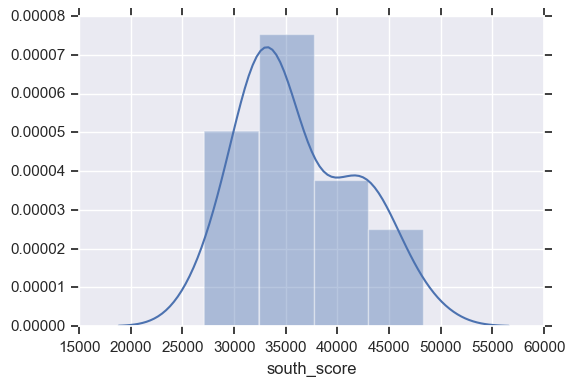

In [97]:
sns.distplot(games[(games["south_position"] == 1) & (games["final_position"] != 1)]["south_score"])

In [93]:
for game_index in hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)]["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019021903gm-0089-0000-f790e5dd&tw=1

http://tenhou.net/3/?log=2019021904gm-0089-0000-f4647516&tw=1

http://tenhou.net/3/?log=2019021912gm-0089-0000-0853c1c5&tw=1

http://tenhou.net/3/?log=2019021914gm-0089-0000-51986fb6&tw=1

http://tenhou.net/3/?log=2019021821gm-0089-0000-eef2ded9&tw=1

http://tenhou.net/3/?log=2019021822gm-0089-0000-8998848d&tw=2

http://tenhou.net/3/?log=2019021905gm-0089-0000-a413f27a&tw=1

http://tenhou.net/3/?log=2019021907gm-0009-0000-9659159b&tw=0

http://tenhou.net/3/?log=2019021914gm-0089-0000-9306e6b6&tw=3

http://tenhou.net/3/?log=2019021916gm-0089-0000-98bd8d82&tw=1

http://tenhou.net/3/?log=2019021920gm-0089-0000-94a08305&tw=2



## Error Analysis

In [38]:
games.head()

,Unnamed: 0,game_index,south_score,final_score,south_position,final_position
0,0,2019021812gm-0089-0000-51a49057&tw=0,13500,21000,4,4
1,1,2019021813gm-0089-0000-4ef9e732&tw=2,26000,22500,3,3
2,2,2019021813gm-0089-0000-28be5cdb&tw=3,29100,9400,2,3
3,3,2019021814gm-0089-0000-c7ee964d&tw=2,27700,28200,2,2
4,4,2019021814gm-0089-0000-2cb9b311&tw=1,22000,23600,3,3


In [39]:
game_indexes_4 = games[games["final_position"]==4]["game_index"]

In [40]:
for game_index in game_indexes_4:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019021812gm-0089-0000-51a49057&tw=0

http://tenhou.net/3/?log=2019021815gm-0089-0000-e7984f1c&tw=3

http://tenhou.net/3/?log=2019021819gm-0089-0000-48eb59f7&tw=2

http://tenhou.net/3/?log=2019021821gm-0089-0000-2d3f42e1&tw=1

http://tenhou.net/3/?log=2019021821gm-0089-0000-5929cc8f&tw=2

http://tenhou.net/3/?log=2019021822gm-0089-0000-1cc2c3fd&tw=2

http://tenhou.net/3/?log=2019021900gm-0089-0000-633d3f1d&tw=1

http://tenhou.net/3/?log=2019021902gm-0089-0000-a71146ce&tw=0

http://tenhou.net/3/?log=2019021903gm-0089-0000-f790e5dd&tw=1

http://tenhou.net/3/?log=2019021904gm-0089-0000-8f27cab3&tw=0

http://tenhou.net/3/?log=2019021914gm-0089-0000-51986fb6&tw=1

http://tenhou.net/3/?log=2019021915gm-0089-0000-887b1f66&tw=3

http://tenhou.net/3/?log=2019021813gm-0009-0000-d3688a6d&tw=1

http://tenhou.net/3/?log=2019021814gm-0009-0000-d1f28565&tw=0

http://tenhou.net/3/?log=2019021818gm-0089-0000-7bb76901&tw=1

http://tenhou.net/3/?log=2019021823gm-0089-0000-b36992c